<h2 style='color:blue' align='center'>使用残差网络在cifar10数据集上进行图像识别</h2>

In [104]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import time
import os
import ssl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Epochs=20

![avatar](small_images.jpg)

CIFAR-10数据集是一个用于监督学习训练的数据集，由60000个样本组成，每个样本都是一张32*32像素的RGB图像，共有10个类别，分别是飞机（airplane）、汽车（automobile）、鸟（bird）、猫（cat）、鹿（deer）、狗（dog）、青蛙（frog）、马（horse）、船（ship）和卡车（truck）。
以下是CIFAR-10数据集的出处链接：
[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cifar10)

In [105]:
#数据预处理
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [106]:
# 数据集根目录
data_root = '/kaggle/input/cifar-10-batches-py-tar-gz/'

# 训练集
trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# 测试集
testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# 残差网络

In [107]:
# 定义带两个卷积路径和一条捷径的残差基本块类
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):  # 初始化函数，in_planes为输入通道数，planes为输出通道数，步长默认为1
        super(BasicBlock, self).__init__()
        # 定义第一个卷积，默认卷积前后图像大小不变但可修改stride使其变化，通道可能改变
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # 定义第一个批归一化
        self.bn1 = nn.BatchNorm2d(planes)
        # 定义第二个卷积，卷积前后图像大小不变，通道数不变
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        # 定义第二个批归一化
        self.bn2 = nn.BatchNorm2d(planes)
        # 定义一条捷径，若两个卷积前后的图像尺寸有变化(stride不为1导致图像大小变化或通道数改变)
        # 捷径通过1×1卷积用stride修改大小以及用expansion修改通道数，以便于捷径输出和两个卷积的输出尺寸匹配相加
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    # 定义前向传播函数，输入图像为x，输出图像为out
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # 第一个卷积和第一个批归一化后用ReLU函数激活
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 第二个卷积和第二个批归一化后与捷径相加
        out = F.relu(out)  # 两个卷积路径输出与捷径输出相加后用ReLU激活
        return out


In [108]:
# 定义残差网络ResNet18
class ResNet(nn.Module):
    # 定义初始函数，输入参数为残差块，残差块数量，默认参数为分类数10
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
# 设置第一层的输入通道数
        self.in_planes = 64
# 定义输入图片先进行一次卷积与批归一化，使图像大小不变，通道数由3变为64得两个操作
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
# 定义第一层，输入通道数64，有num_blocks[0]个残差块，残差块中第一个卷积步长自定义为1
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
# 定义第二层，输入通道数128，有num_blocks[1]个残差块，残差块中第一个卷积步长自定义为2
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
# 定义第三层，输入通道数256，有num_blocks[2]个残差块，残差块中第一个卷积步长自定义为2
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
# 定义第四层，输入通道数512，有num_blocks[3]个残差块，残差块中第一个卷积步长自定义为2
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
# 定义全连接层，输入512*block.expansion个神经元，输出10个分类神经元
        self.linear = nn.Linear(512*block.expansion, num_classes)
# 定义创造层的函数，在同一层中通道数相同，输入参数为残差块，通道数，残差块数量，步长

    def _make_layer(self, block, planes, num_blocks, stride):
        # strides列表第一个元素stride表示第一个残差块第一个卷积步长，其余元素表示其他残差块第一个卷积步长为1
        strides = [stride] + [1]*(num_blocks-1)
# 创建一个空列表用于放置层
        layers = []
# 遍历strides列表，对本层不同的残差块设置不同的stride
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))  # 创建残差块添加进本层
            self.in_planes = planes * block.expansion  # 更新本层下一个残差块的输入通道数或本层遍历结束后作为下一层的输入通道数
        return nn.Sequential(*layers)  # 返回层列表
# 定义前向传播函数，输入图像为x，输出预测数据

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # 第一个卷积和第一个批归一化后用ReLU函数激活
        out = self.layer1(out)  # 第一层传播
        out = self.layer2(out)  # 第二层传播
        out = self.layer3(out)  # 第三层传播
        out = self.layer4(out)  # 第四层传播
        out = F.avg_pool2d(out, 4)  # 经过一次4×4的平均池化
        out = out.view(out.size(0), -1)  # 将数据flatten平坦化
        out = self.linear(out)  # 全连接传播
        return out


In [109]:
# 定义准确度评估函数(参数为数据装载器，网络模型，运算设备)
def evaluate_accuracy(data_iter, net, device=None):
    # 如果没指定device就使用net的device
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    # 累计正确样本设为0.0，累计预测样本数设为0
    acc_sum, n = 0.0, 0
    # 准确度评估阶段，with torch.no_grad()封装内关闭梯度计算功能
    with torch.no_grad():
        # 从数据加载器上批量读取数据X与标签y
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):  # 若网络模型继承自torch.nn.Module
                net.eval()  # 进入评估模式, 这会关闭dropout，以CPU进行准确度累加计算
                # 判断net(X.to(device)).argmax(dim=1)即X经net后输出的批量预测列表中每一个样本输出的最大值和y.to(device)此样本真实标签是否相同，
                # 若相同则表示预测正确，等号表达式为True，值为1；否则表达式为False，值为0。将批量所有样本的等号表达式值求和后再加给acc_sum
                # 每一次acc_sum增加一批量中预测正确的样本个数，随着不断的遍历，acc_sum表示累计的所有预测正确的样本个数
                acc_sum += (net(X.to(device)).argmax(dim=1) ==
                            y.to(device)).float().sum().cpu().item()
                net.train()  # 改回训练模式
            else:  # 若使用自定义的模型
                # 查看net对象中是否有变量名为is_training的参数，若有将is_training设置成False后遍历累加每一批量中的预测正确的样本数量
                if ('is_training' in net.__code__.co_varnames):
                    acc_sum += (net(X, is_training=False).argmax(dim=1)
                                == y).float().sum().item()
                # 若net对象中没有变量名为is_training的参数，则遍历累加每一批量中的预测正确的样本数量
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            # 每一次y.shape[0]表示一批量中标签个数，也就是样本个数。所以n表示累计的所有预测过的样本个数，无论正确与否
            n += y.shape[0]
    return acc_sum / n  # 用累计的所有预测正确的样本个数除以累计的所有预测过的样本个数得到准确率


In [110]:
def classify(net, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [111]:
# 定义训练函数(参数为网络模型，训练加载器，测试加载器，批量样本数，优化器，运算设备，训练回合数)
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)  # 网络模型搬移至指定的设备上
    print("training on ", device)  # 查看当前训练所用的设备
    loss = torch.nn.CrossEntropyLoss()  # 损失函数loss使用交叉熵损失函数
    batch_count = 0  # 批量计数器设为0
    for epoch in range(num_epochs):  # 循环训练回合，每回合会以批量为单位训练完整个训练集，一共训练num_epochs个回合
        # 每一训练回合初始化累计训练损失函数为0.0，累计训练正确样本数为0.0，训练样本总数为0，start为开始计时的时间点
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:  # 循环每次取一批量的图像与标签
            X = X.to(device)  # 将图像搬移至指定设备上
            y = y.to(device)  # 将标签搬移至指定设备上
            y_hat = net(X)  # 将批量图像数据X输入网络模型net，得到输出批量预测数据y_hat
            l = loss(y_hat, y)  # 计算批量预测标签y_hat与批量真实标签y之间的损失函数l
            optimizer.zero_grad()  # 优化器的梯度清零
            l.backward()  # 对批量损失函数l进行反向传播计算梯度
            optimizer.step()  # 优化器的梯度进行更新，训练所得参数也更新
            train_l_sum += l.cpu().item()  # 将本批量损失函数l加至训练损失函数累计train_l_sum中
            # 将本批量预测正确的样本数加至累计预测正确样本数train_acc_sum中
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]  # 将本批量训练的样本数，加至训练样本总数
            batch_count += 1  # 批量计数器加1
        # 对本回合训练所得网络模型参数，以批量为单位，测试全集去验证，得到测试集预测准确度
        test_acc = evaluate_accuracy(test_iter, net)
        # 打印回合数，每回合平均损失函数，每回合的训练集准确度，每回合的测试集准确度，每回合用时
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    test_acc = evaluate_accuracy(test_iter, net)
    print('Accuracy of the network on the 10000 test images: %.3f %%' % (100*test_acc))
    classify(net,device)


In [112]:
net = ResNet(BasicBlock, [2, 2, 2, 2])
#定义一个训练批量的样本数
batch_size=128
#构建可迭代的数据装载器(参数为数据集，一个批量的样本数，是否乱序，工作线程数)
train_iter = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
#多GPU训练及优化
if device == 'cuda':
#对象net可进行多GPU并行处理
    net = torch.nn.DataParallel(net)
#cudnn是英伟达为深度神经网络开发的GPU加速库,让内置的cudnn的auto-tuner自动寻找最适合当前配置的高效算法,来达到优化运行效率的问题。
    cudnn.benchmark = True
#设置学习率lr，训练回合数num_epochs
lr, num_epochs = 0.01, Epochs
#设置优化器为Adam优化器，参数为网络模型的参数和学习率
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#开始训练模型，参数为网络模型，训练加载器，测试加载器，批量大小，优化器，运算设备，训练回合数
train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)
resnet18=net


training on  cuda
epoch 1, loss 1.7295, train acc 0.373, test acc 0.508, time 26.9 sec
epoch 2, loss 0.5758, train acc 0.588, test acc 0.556, time 26.9 sec
epoch 3, loss 0.2874, train acc 0.694, test acc 0.729, time 26.9 sec
epoch 4, loss 0.1684, train acc 0.763, test acc 0.766, time 27.0 sec
epoch 5, loss 0.1077, train acc 0.811, test acc 0.747, time 26.9 sec
epoch 6, loss 0.0749, train acc 0.844, test acc 0.806, time 27.0 sec
epoch 7, loss 0.0543, train acc 0.868, test acc 0.822, time 27.0 sec
epoch 8, loss 0.0406, train acc 0.888, test acc 0.845, time 26.9 sec
epoch 9, loss 0.0307, train acc 0.903, test acc 0.841, time 27.0 sec
epoch 10, loss 0.0228, train acc 0.922, test acc 0.827, time 26.9 sec
epoch 11, loss 0.0182, train acc 0.932, test acc 0.854, time 26.9 sec
epoch 12, loss 0.0141, train acc 0.942, test acc 0.838, time 27.0 sec
epoch 13, loss 0.0111, train acc 0.951, test acc 0.855, time 26.9 sec
epoch 14, loss 0.0089, train acc 0.957, test acc 0.846, time 26.9 sec
epoch 15, l

# VGG加深网络

In [113]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512 * 4 * 4, 1024)
        self.drop = nn.Dropout()
        self.fc15 = nn.Linear(1024, 1024)
        self.fc16 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc14(x))
        x = self.drop(x)
        x = F.relu(self.fc15(x))
        x = self.drop(x)
        x = self.fc16(x)

        return x

    def train_sgd(self, device):

        optimizer = optim.SGD(self.parameters(), lr=0.01)
        path = 'weights.tar'
        initepoch = 0

        if os.path.exists(path) is not True:
            loss = nn.CrossEntropyLoss()


        else:
            checkpoint = torch.load(path)
            self.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            initepoch = checkpoint['epoch']
            loss = checkpoint['loss']

        for epoch in range(initepoch, Epochs):  # loop over the dataset multiple times
            timestart = time.time()

            running_loss = 0.0
            total = 0
            correct = 0
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item()

                if i % 500 == 499:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch, i, running_loss / 500))
                    running_loss = 0.0
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    print('Accuracy of the network on the %d tran images: %.3f %%' % (total,
                                                                                      100.0 * correct / total))
                    total = 0
                    correct = 0
                    torch.save({'epoch': epoch,
                                'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss
                                }, path)
            
            print('epoch %d cost %3f sec' % (epoch, time.time() - timestart))

        print('Finished Training')

    def test(self, device):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3f %%' % (100.0 * correct / total))

    def classify(self, device):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = self(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


In [114]:
if __name__ == '__main__':
    net = Net()
    net = net.to(device)
    net.train_sgd(device)
    net.test(device)
    net.classify(device)

[16,   499] loss: 0.1762
Accuracy of the network on the 100 tran images: 94.000 %
epoch 16 cost 15.114440 sec
[17,   499] loss: 0.1626
Accuracy of the network on the 100 tran images: 93.000 %
epoch 17 cost 15.087104 sec
[18,   499] loss: 0.1518
Accuracy of the network on the 100 tran images: 91.000 %
epoch 18 cost 15.103201 sec
[19,   499] loss: 0.1336
Accuracy of the network on the 100 tran images: 95.000 %
epoch 19 cost 15.086041 sec
Finished Training
Accuracy of the network on the 10000 test images: 83.220 %
Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 82 %
Accuracy of   cat : 66 %
Accuracy of  deer : 75 %
Accuracy of   dog : 62 %
Accuracy of  frog : 85 %
Accuracy of horse : 80 %
Accuracy of  ship : 88 %
Accuracy of truck : 87 %


In [115]:
# 初始化空列表用于存储所有数据
X_train, y_train = [], []

# 遍历所有训练集数据
for batch_X, batch_y in trainloader:
    X_train.append(batch_X)
    y_train.append(batch_y)

# 将列表中的 Tensor 拼接成一个整体
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)

# 打印样本形状
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: torch.Size([50000, 3, 32, 32])
y_train shape: torch.Size([50000])


In [116]:
# 同样方式处理测试集
X_test, y_test = [], []

for batch_X, batch_y in testloader:
    X_test.append(batch_X)
    y_test.append(batch_y)

X_test = torch.cat(X_test, dim=0)
y_test = torch.cat(y_test, dim=0)

# 打印样本形状
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: torch.Size([10000, 3, 32, 32])
y_test shape: torch.Size([10000])


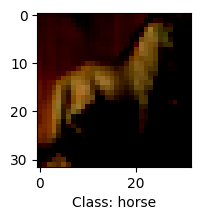

In [117]:
import matplotlib.pyplot as plt

def plot_sample(X, y, index):
    plt.figure(figsize=(15, 2))
    img = X[index].permute(1, 2, 0)  # 使用permute替代transpose
    plt.imshow(img)
    plt.xlabel(f"Class: {classes[y[index].item()]}")

# 调用这个函数
plot_sample(X_train, y_train, 10)



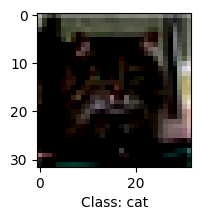

In [118]:
plot_sample(X_train, y_train, 1)

# ANN

In [119]:
from keras import models, layers

# 将 PyTorch 张量转换为 NumPy 数组
X_train_np = X_train.permute(0, 2, 3, 1).numpy()  # 调整维度顺序
y_train_np = y_train.numpy()

# 创建 Keras 模型
ann = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # 直接设置输入形状
    layers.Flatten(),
    # ... 其他层 ...
    layers.Dense(10, activation='softmax')    
])

# 编译模型
ann.compile(optimizer='SGD',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# 在 NumPy 数组上训练模型
ann.fit(X_train_np, y_train_np, epochs=Epochs)



Epoch 1/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8733 - accuracy: 0.3467
Epoch 2/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7888 - accuracy: 0.3813
Epoch 3/20
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7646 - accuracy: 0.3924
Epoch 4/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7489 - accuracy: 0.3983
Epoch 5/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7399 - accuracy: 0.4005
Epoch 6/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7326 - accuracy: 0.4052
Epoch 7/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7254 - accuracy: 0.4076
Epoch 8/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7209 - accuracy: 0.4066
Epoch 9/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7164 - accuracy: 0.4112
Epoch 10/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.712

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 调整 PyTorch 测试数据的维度顺序
X_test_permuted = X_test.permute(0, 2, 3, 1)

# 将 PyTorch 测试数据转换为 NumPy 数组
X_test_np = X_test_permuted.numpy()

# 使用 Keras 模型进行预测
y_pred = ann.predict(X_test_np)

# 获取预测类别
y_pred_classes = [np.argmax(element) for element in y_pred]

# 打印分类报告等信息
print("Classification Report:\n", classification_report(y_test, y_pred_classes))



313/313 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.47      0.46      1000
           1       0.43      0.40      0.41      1000
           2       0.29      0.29      0.29      1000
           3       0.29      0.23      0.26      1000
           4       0.32      0.21      0.25      1000
           5       0.31      0.33      0.32      1000
           6       0.36      0.51      0.42      1000
           7       0.40      0.48      0.44      1000
           8       0.54      0.46      0.49      1000
           9       0.43      0.46      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000



# CNN

In [121]:
cnn = models.Sequential([
    layers.Reshape((32, 32, 3)), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [122]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
cnn.fit(X_train_np, y_train_np, epochs=Epochs)

Epoch 1/20
1563/1563 [==============================] - 6s 3ms/step - loss: 1.4654 - accuracy: 0.4828
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1995 - accuracy: 0.5814
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1068 - accuracy: 0.6141
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0381 - accuracy: 0.6373
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9827 - accuracy: 0.6571
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9390 - accuracy: 0.6715
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8984 - accuracy: 0.6853
Epoch 8/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8610 - accuracy: 0.6992
Epoch 9/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8242 - accuracy: 0.7101
Epoch 10/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.789

In [124]:
y_test_np = y_test.detach().numpy()
print("ANN:")
ann.evaluate(X_test_np,y_test_np)
print("CNN:")
cnn.evaluate(X_test_np,y_test_np)
print("VGG:")
net.test(device)
print("ResNet:")
test_acc = evaluate_accuracy(test_iter, resnet18)
print('Accuracy of the network on the 10000 test images: %.3f %%' % (100*test_acc))

ANN:
313/313 [==============================] - 1s 2ms/step - loss: 1.7963 - accuracy: 0.3832
CNN:
313/313 [==============================] - 1s 2ms/step - loss: 1.3511 - accuracy: 0.6285
VGG:
Accuracy of the network on the 10000 test images: 82.980 %
ResNet:
Accuracy of the network on the 10000 test images: 85.890 %


可以看出，在训练了20轮后，ANN的精度在38%左右，CNN的精度在63%左右，VGG加深网络的精度在82.98%，Resnet18残差网络的精度在85.89%，残差网络的识别效果最好